In [4]:

import numpy as np 
import pandas as pd 

from zipfile import ZipFile

import os


*Importing Library*

In [6]:
!gdown https://drive.google.com/uc?id=1qAlledjFkWfr0XZnMxeqFWdA8uwkSLMc
zf = ZipFile('fruit-360.zip', 'r')
zf.extractall('Fruit-360')
zf.close()

data_dir = os.path.join("/content/Fruit-360/fruits-360")
train_path = os.path.join(data_dir, 'Training/')
test_path = os.path.join(data_dir,"Test/")

#train_path = "/kaggle/input/fruits/fruits-360/Training/"
#test_path = "/kaggle/input/fruits/fruits-360/Test/"
#data_dir = '../input/fruits/fruits-360'
print( os.listdir(data_dir))
classes = os.listdir(data_dir + "/Training")
print("No of Class",len(classes))

Downloading...
From: https://drive.google.com/uc?id=1qAlledjFkWfr0XZnMxeqFWdA8uwkSLMc
To: /content/fruit-360.zip
797MB [00:04, 169MB/s]
['Training', 'test-multiple_fruits', 'papers', 'readme.md', 'Test', 'LICENSE']
No of Class 131


In [7]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image  import ImageDataGenerator, img_to_array,load_img
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor


from sklearn.model_selection import train_test_split

**Loading Data**

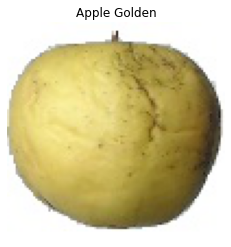

(100, 100, 3)


In [8]:
img = load_img(train_path + "Apple Golden 1/0_100.jpg")
plt.imshow(img)
plt.title("Apple Golden")
plt.axis("off")
plt.show()
shape_of_image = img_to_array(img)
print(shape_of_image.shape)

In [9]:

dataset = ImageFolder(data_dir + '/Training', transform=ToTensor())
print('Size of training dataset :', len(dataset))
test = ImageFolder(data_dir + '/Test', transform=ToTensor())
print('Size of test dataset :', len(test))


Size of training dataset : 67692
Size of test dataset : 22688


# Shape of Image

In [10]:
img, label = dataset[6560]
print(img.shape)

torch.Size([3, 100, 100])


In [11]:
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

7

In [12]:
# data loader
train_loader = DataLoader(dataset, batch_size = batch_size, 
                          shuffle = True, 
                          num_workers=25, 
                          pin_memory=True)
test_loader = DataLoader(test, 
                         batch_size = batch_size, 
                         shuffle = True, 
                         num_workers=25, 
                         pin_memory=True)


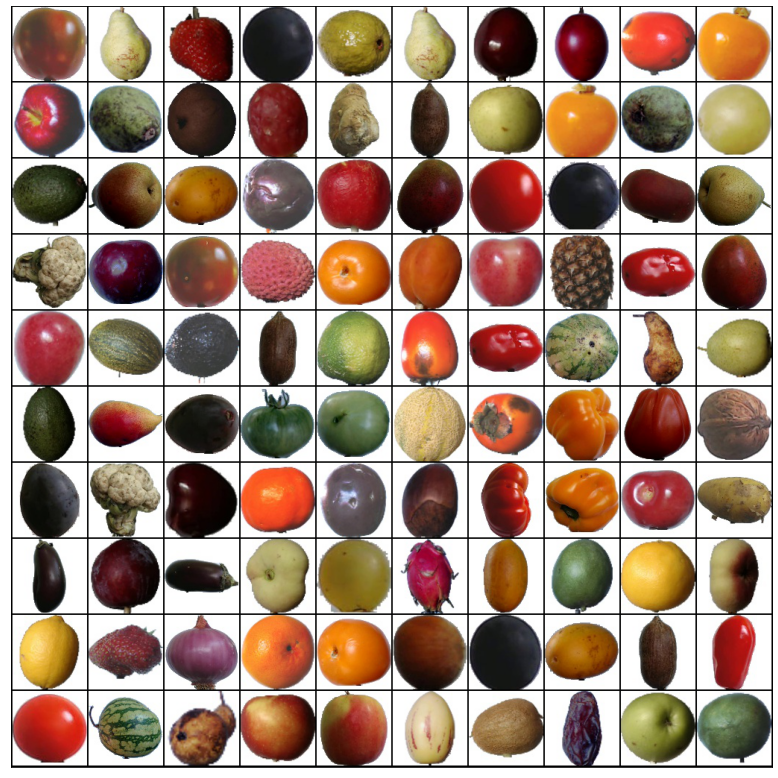

In [13]:
from torchvision.utils import make_grid

for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(14,14))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
    break

In [14]:
# Create ANN Model
class ANNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        
        # Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim,hidden_dim ) 
        # Non-linearity 2 : Tanh
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 150 --> 150
        self.fc3 =nn.Linear(hidden_dim,hidden_dim ) 
        # Non-linearity 3 ReLU
        self.relu3 = nn.ReLU()
        
        # Linear function 4 (readout): 150 --> ?????????
        self.fc4 = nn.Linear(hidden_dim,output_dim ) 
    
    def forward(self, x):
        # Linear function 1
        out=self.fc1(x)
        
        # Non-linearity 1
        out=self.relu1(out)
        
        
        # Linear function 2
        out=self.fc2(out)
        
        # Non-linearity 2
        out=self.tanh2(out)
        
        
        # Linear function 2
        out=self.fc3(out)
        
        # Non-linearity 2
        out=self.relu3(out)
        
        
        # Linear function 4 (readout)
        out=self.fc4(out)
        return out

# instantiate ANN
input_dim =3*100*100

#hidden layer dim is one of the hyper parameter and it should be chosen and tuned.
hidden_dim = 150 

output_dim = 131

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 3*100*100))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        
        loss=error(outputs,labels)
        # Calculating gradients
        loss.backward()

        
        # Update parameters
        
        optimizer.step()

        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0

            # Predict test dataset
            for images, labels in test_loader:

                test = Variable(images.view(-1,3*100*100))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 3.325946569442749  Accuracy: 22.37746810913086 %
Iteration: 1000  Loss: 2.1295902729034424  Accuracy: 44.04971694946289 %
Iteration: 1500  Loss: 1.4919345378875732  Accuracy: 55.152503967285156 %
Iteration: 2000  Loss: 0.9570002555847168  Accuracy: 65.77045440673828 %
Iteration: 2500  Loss: 0.5688128471374512  Accuracy: 74.56805419921875 %
Iteration: 3000  Loss: 0.5112345218658447  Accuracy: 77.63575744628906 %
Iteration: 3500  Loss: 0.2798599898815155  Accuracy: 81.10454559326172 %
Iteration: 4000  Loss: 0.2715151906013489  Accuracy: 82.79266357421875 %
Iteration: 4500  Loss: 0.221263587474823  Accuracy: 84.15902709960938 %


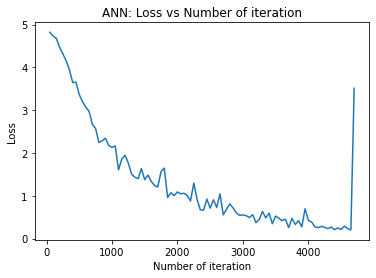

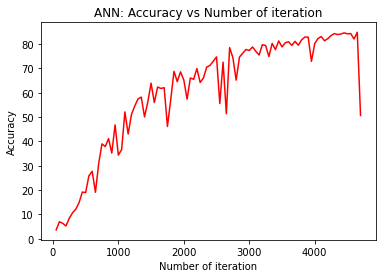

In [ ]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()